In [8]:
import pandas as pd
import numpy as np
import pathlib
import glob
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("C:\\Users\\nguye\\OneDrive\\Documents\\Python Scripts\\masterthesis\\main\\headline_cpi_ver2.xlsx")

In [215]:
df_cpi = df[df["item_name"] == "All items"]
df_cpi = df_cpi[["month","value"]].reset_index(drop = True).rename(columns = {"value": "cpi"})
df_cpi["month"] = pd.to_datetime(df_cpi["month"]).dt.date

In [5]:
#stationary check
adfuller_cpi = adfuller(df_cpi["cpi"])
print('ADF Statistic: %f' % adfuller_cpi[0])
print('p-value: %f' % adfuller_cpi[1])
print('Critical Values:')
for key, value in adfuller_cpi[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.298211
p-value: 0.977262
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [7]:
#transform for stationary
#level 1
adfuller_cpi1 = adfuller(df_cpi["cpi"].diff(1).dropna())
print('ADF Statistic: %f' % adfuller_cpi1[0])
print('p-value: %f' % adfuller_cpi1[1])
print('Critical Values:')
for key, value in adfuller_cpi1[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.441664
p-value: 0.000250
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Average RMSE across windows: 0.7790224655795068 for 3 months


c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

Average RMSE across windows: 1.3025646584788249 for 6 months


c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nguye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Average RMSE across windows: 2.0269734835542477 for 12 months


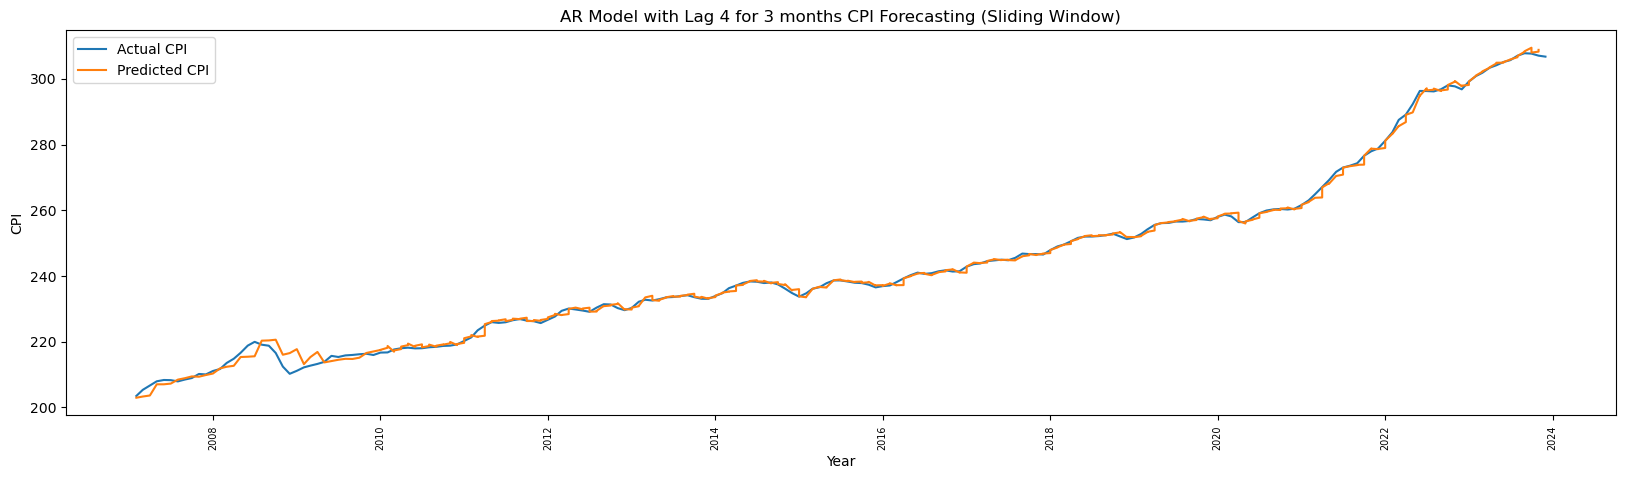

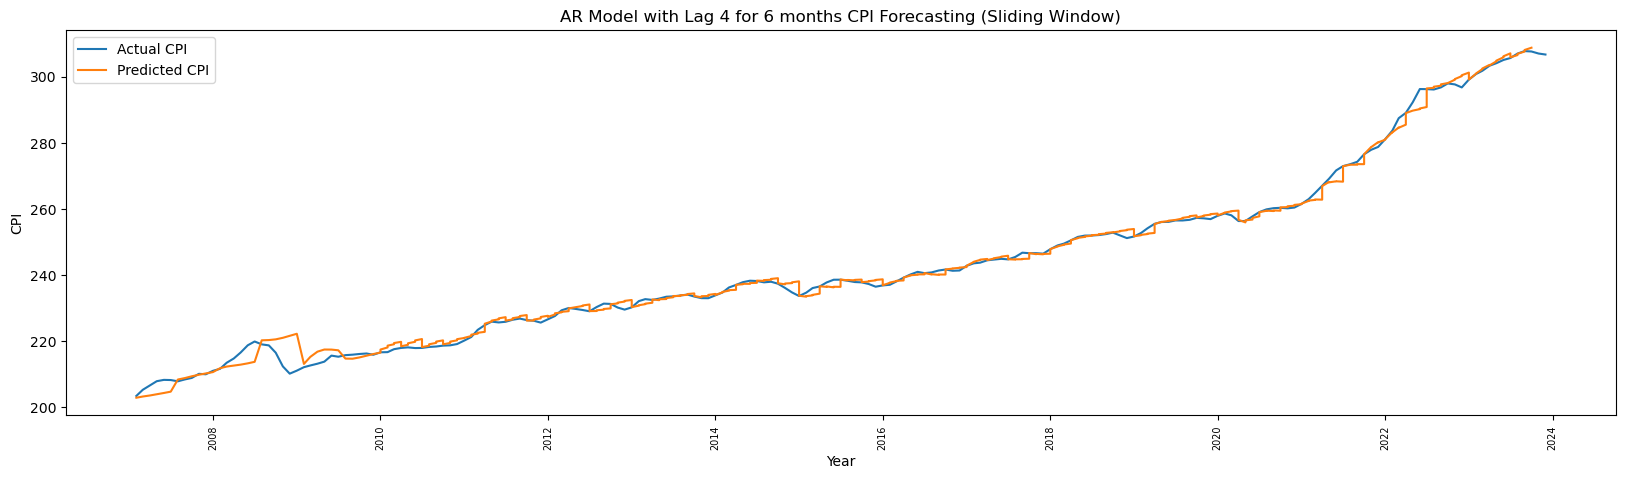

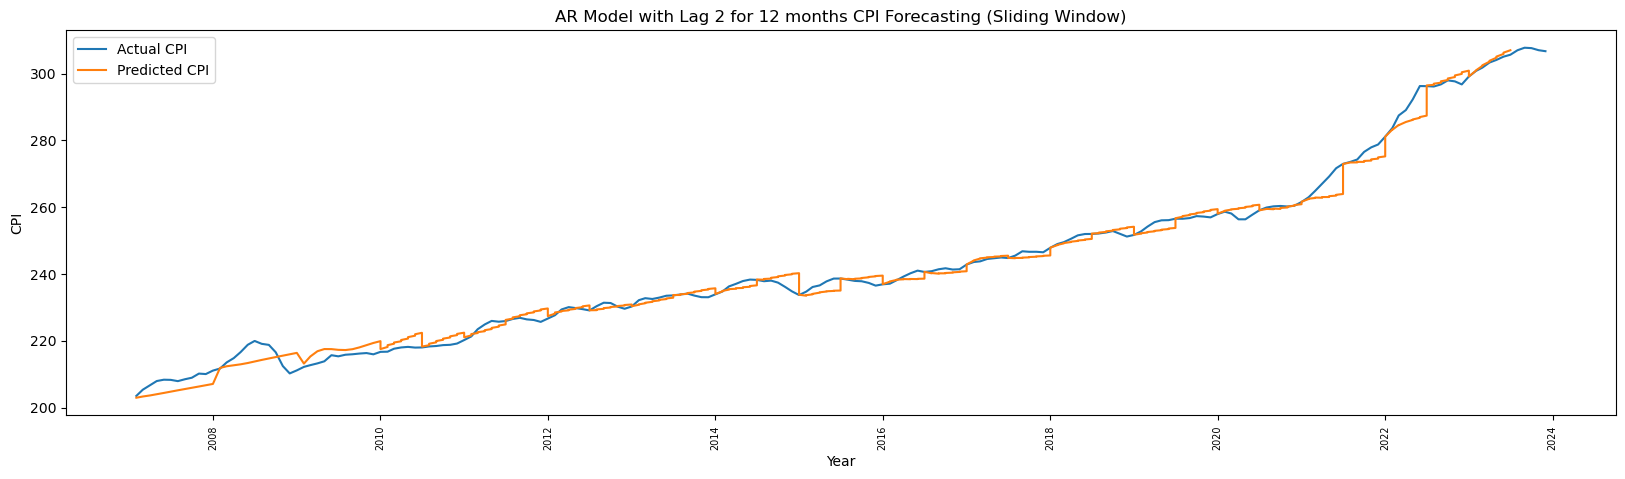

In [240]:
forecast_horizon_list = [3,6,12]


for j in forecast_horizon_list:
    # Assuming you have a pandas DataFrame 'df' with a 'Date' column and 'CPI' column
    # You may need additional columns for other indicators
    df_cpi_c = df_cpi.copy(deep=True)
    df_cpi_c["cpi_diff"] = df_cpi_c["cpi"].diff(1)
    ar_df = df_cpi_c.iloc[1:].set_index("month")


    # Define window size and forecast horizon
    window_size = 7*12  # 7 years
    forecast_horizon = j

    # Initialize lists to store RMSE values and predictions
    rmse_values = []
    all_predictions = []

    # Iterate through the data using a sliding window
    for i in range(window_size, len(ar_df)-forecast_horizon+1,forecast_horizon):
        # Split the data into training and testing sets for the current window
        train_window = ar_df.iloc[i-window_size:i]
        test_window = ar_df.iloc[i:i+forecast_horizon]
        
        # Find the optimal lag length using AIC
        results = []
        for lag in range(1, 5):
            model = AutoReg(train_window['cpi_diff'], lags=lag)
            result = model.fit()
            results.append({'lag': lag, 'AIC': result.aic})

        # Find the lag with the minimum AIC
        best_lag = min(results, key=lambda x: x['AIC'])['lag']

        # Fit the AR model with the optimal lag to the training data
        model = AutoReg(train_window['cpi_diff'], lags=best_lag)
        ar_model = model.fit()

        # Forecast using the AR model on the test set
        predictions_diff = ar_model.predict(start=len(train_window), end=len(train_window)+forecast_horizon-1)
        predictions = np.cumsum(predictions_diff) + np.sum(ar_df["cpi_diff"].iloc[:i].values) + df_cpi["cpi"][0]
        


        # Evaluate the model
        rmse_value = rmse(test_window['cpi'], predictions)
        rmse_values.append(rmse_value)
        
        # Store predictions for visualization
        # Extend the predictions with the correct date indices
        prediction_indices = ar_df.index[i:i+forecast_horizon]
        all_predictions.extend(zip(prediction_indices,predictions))
        

    # Extract the indices and values separately for plotting
    predicted_dates, predicted_values = zip(*all_predictions)
        

    # Plot actual vs. predicted CPI values
    plt.figure(figsize=(20,5))
    plt.plot(ar_df.index[window_size:], ar_df['cpi'].iloc[window_size:], label='Actual CPI')
    plt.plot(predicted_dates, predicted_values,label='Predicted CPI')
    import matplotlib.dates as mdates
    dtFmt = mdates.DateFormatter('%Y') # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.xlabel('Year')
    plt.ylabel('CPI')
    plt.title(f'AR Model with Lag {best_lag} for {j} months CPI Forecasting (Sliding Window)')
    plt.legend()
    plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)

    # Print the average RMSE over all windows
    average_rmse = np.mean(rmse_values)
    print(f'Average RMSE across windows: {average_rmse} for {j} months')